In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
from astropy.time import Time

In [2]:
def readfile(filename):
    with open(filename, 'r') as fin:
        # human readable string for information
        comment = fin.readline()
        # timestamps [channel velocities]
        header = fin.readline()
        data = fin.readlines()

    chan_vel = np.array(header.strip().split(',')[1:-1], dtype=float)

    for cntr, line in enumerate(data):
        if cntr < 1:
            file_data = np.array(line.strip().split(',')[:-1], dtype=float)
        else:
            file_data = np.vstack([file_data, np.array(line.strip().split(',')[:-1], dtype=float)])

    timestamps = file_data[:,0]
    spectra = file_data[:,1:]
    
    return [chan_vel, timestamps, spectra]

In [3]:
def ts2datetime(timestamps, epoch=0., tsformat='mjd'):
    return Time(timestamps + epoch, format=tsformat)

In [4]:
filename = 'vmic.tscatJD'
[chan_vel, timestamps, spectra] = readfile(filename)
ts_jd = ts2datetime(timestamps)
channel = 3
chan_data = spectra[:, channel]

In [5]:
ts = ts_jd[25:]
y = chan_data - chan_data.mean()
y = y[25:]

Text(0.5,0,'Timestamp')

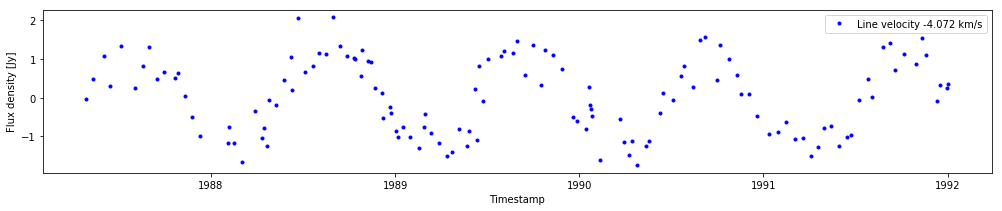

In [6]:
fig= plt.subplots(figsize=(17,3),
                  facecolor='white')
ax = plt.subplot(111)
ax.plot(ts.datetime,
        y,
        'b.',
        label=r'Line velocity {} km/s'.format(chan_vel[channel]))
ax.legend(loc=0)
ax.set_ylabel('Flux density [Jy]')
ax.set_xlabel('Timestamp')

In [7]:
def smooth_timeseries(ts_mjd, signal, verbose=False):
    import time
    from datetime import datetime
    # removing outliers and smoothing with auto-regressive time series models
    import statsmodels.tsa.api as tsa
    # ARIMA(1,0,0) = first-order autoregressive model: if the series is stationary
    # and autocorrelated, perhaps it can be predicted as a multiple of its own
    # previous value, plus a constant.
    arma =tsa.ARIMA(signal, order =(1,0,0))
    armaresults= arma.fit().predict()

    # upsample to regular grid
    import pandas
    panda_dates = pandas.Series([pandas.to_datetime(date) for date in ts_mjd])
    pd = pandas.DataFrame(armaresults, index=panda_dates)
    pandasresults = pd
    
    # gap filling with Kalman filters
    from pykalman import KalmanFilter
    kf = KalmanFilter(em_vars=['transition_covariance', 'observation_covariance'])
    measurements=np.ma.masked_invalid(pandasresults.values)
    measurement_mask=np.ma.array(np.ma.masked_invalid(pandasresults.values).flatten())
    kalmanresults = kf.em(measurement_mask).smooth(measurement_mask)[0]
    
    morepandasresults = pd.resample('D').pad()
    
    if verbose:
        fig = plt.figure(figsize=[11, 6])
        plt.subplots_adjust(left=0.05, right=0.85)
        plt.plot(ts_mjd, signal, '*', label='raw')
        plt.plot(ts_mjd, armaresults, 'b.', label='timeseries')
        plt.plot(morepandasresults.index, morepandasresults.values, 'y', label='upsampled')
        plt.plot(pandasresults.index, kalmanresults, 'c', label='smoothed')
        plt.legend(bbox_to_anchor=(1.17, 0.9))
        plt.ylabel('Flux density (Jy)')
        plt.xlabel('Time')

    timestamps = pandasresults.index
    return [timestamps, kalmanresults.flatten()]

/home/jupyter/.local/lib/python2.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


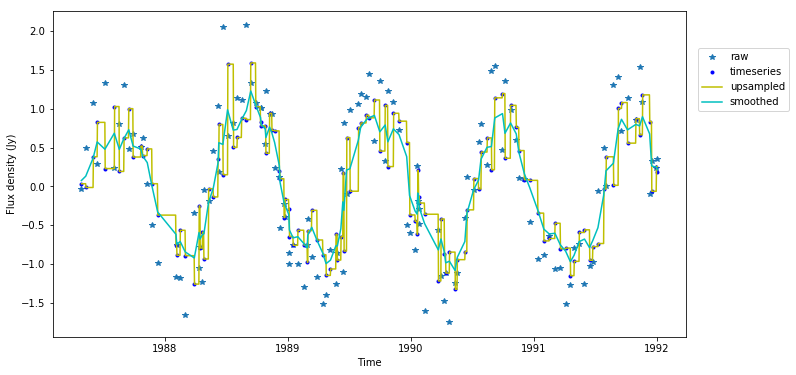

In [8]:
[kalmants, kalmanresults] = smooth_timeseries(ts.datetime, y, verbose=True)

<StemContainer object of 3 artists>

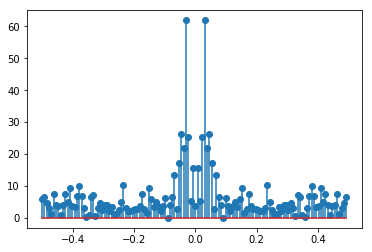

In [9]:
w = np.fft.fft(y)
freqs = np.fft.fftfreq(len(w))
fft_channel=np.fft.fftshift(w)
freqs_channel = np.fft.fftshift(freqs)
plt.stem(freqs_channel, np.abs(fft_channel))

In [10]:
def fourier_periodogram(t, y, df=None):
    N = len(t)
    if df is None:
        frequency = np.fft.fftfreq(N, t[1] - t[0])
    else:
        frequency = np.fft.fftfreq(N, df)
    y_fft = np.fft.fft(y)
    positive = (frequency > 0)
    return frequency[positive], (1. / N) * abs(y_fft[positive]) ** 2

Text(0.03,0.93,'period = 429.544 days')

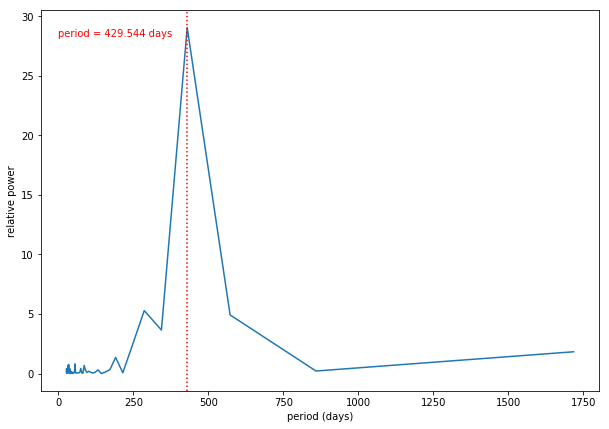

In [11]:
frequency, PSD_fourier = fourier_periodogram(ts.value, y)
period = 1./frequency # period is the inverse of frequency
best_period = 1./frequency[np.argmax(PSD_fourier)]  # period with most power / strongest signal
best_freq = frequency[np.argmax(PSD_fourier)]

fig= plt.subplots(figsize=(10,7),
                  facecolor='white')
ax = plt.subplot(111)
ax.plot(period, PSD_fourier)
ax.axvline(best_period,color='r',linestyle=':');
ax.set_xlabel('period (days)')
ax.set_ylabel('relative power')
ax.text(0.03,0.93,'period = {:.3f} days'.format(best_period),transform=ax.transAxes,color='r')

429.0 1970-01-01 00:07:09


Text(0.03,0.93,'period = 429.000 days')

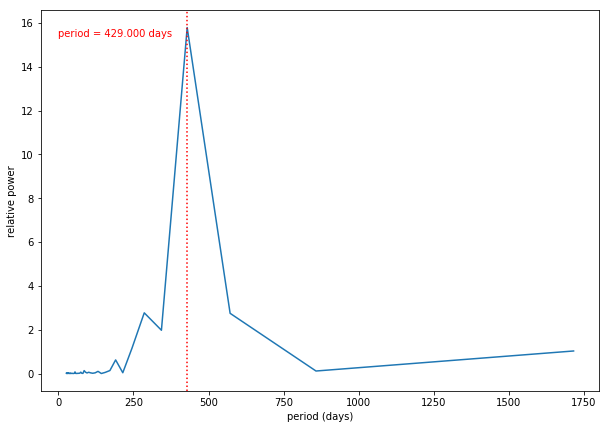

In [12]:
frequency, PSD_fourier = fourier_periodogram(kalmants, kalmanresults, df=(kalmants[1] - kalmants[0]).days)

period = 1./frequency # period is the inverse of frequency
best_period = 1./frequency[np.argmax(PSD_fourier)]  # period with most power / strongest signal
best_freq = frequency[np.argmax(PSD_fourier)]

from datetime import datetime
print best_period, datetime.fromtimestamp(best_period)

fig= plt.subplots(figsize=(10,7),
                  facecolor='white')
ax = plt.subplot(111)
ax.plot(period, PSD_fourier)
ax.axvline(best_period,color='r',linestyle=':');
ax.set_xlabel('period (days)')
ax.set_ylabel('relative power')
ax.text(0.03,0.93,'period = {:.3f} days'.format(best_period),transform=ax.transAxes,color='r')